# Prise en Mains

In [2]:
import numpy as np
import matplotlib.pyplot as plt

### Solution exacte de l'équation u'=-u.

In [4]:
def u_exact(t):
    return np.exp(-t)

### Méthode d'Euler explicite

In [5]:
def euler_explicit(u0, t):
    u = np.zeros_like(t)
    u[0] = u0
    dt = t[1] - t[0]
    for n in range(len(t)-1):
        u[n+1] = u[n] + dt * (-u[n])
    return u


### Comparaison solution exacte / approchée

In [6]:
N_example = 100
t_example = np.linspace(0, 1, N_example)
u_approx_example = euler_explicit(1.0, t_example)
u_true_example = u_exact(t_example)

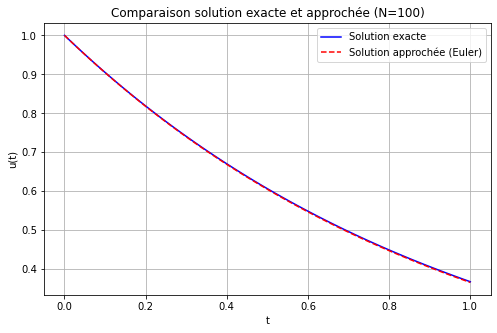

In [7]:
plt.figure(figsize=(8,5))
plt.plot(t_example, u_true_example, label="Solution exacte", color="blue")
plt.plot(t_example, u_approx_example, '--', label="Solution approchée (Euler)", color="red")
plt.xlabel("t")
plt.ylabel("u(t)")
plt.title("Comparaison solution exacte et approchée (N=100)")
plt.legend()
plt.grid(True)
plt.show()

### Evaluation de l'erreur L² en fonction de la précision du maillage

In [8]:
N_values = np.logspace(1, 4, 10, dtype=int)  # de 10 à 10000 points
errors_L2 = []

In [9]:
for N in N_values:
    t = np.linspace(0, 1, N)
    dt = t[1] - t[0]
    u_approx = euler_explicit(1.0, t)
    u_true = u_exact(t)
    error_L2 = np.sqrt(np.sum((u_true - u_approx)**2) * dt)  # norme L2 discrète
    errors_L2.append(error_L2)

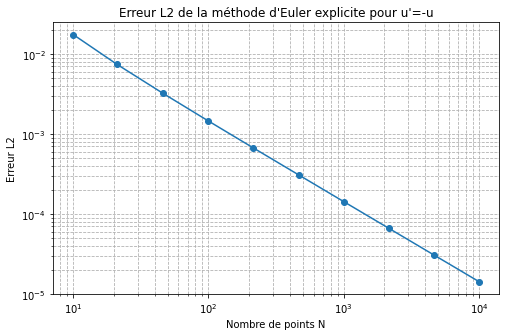

In [10]:
plt.figure(figsize=(8,5))
plt.loglog(N_values, errors_L2, marker='o')
plt.xlabel("Nombre de points N")
plt.ylabel("Erreur L2")
plt.title("Erreur L2 de la méthode d'Euler explicite pour u'=-u")
plt.grid(True, which="both", ls="--")
plt.show()

# Équation ADRS en 2D

L'équation d'advection-diffusion-réaction avec source pour une fonction $u(x, y, t)$ définie sur un domaine $\Omega \subset \mathbb{R}^2$ s'écrit :

$$
\frac{\partial u}{\partial t} + \mathbf{V} \cdot \nabla u - \nu \Delta u = -\lambda u + f(x, y, t)
$$

où :

- $u(x, y, t)$ : quantité transportée (concentration, température, etc.)  
- $\mathbf{V} = (V_x(x, y, t), V_y(x, y, t))$ : champ de vitesse (advection)  
- $\nu$ : coefficient de diffusion (positive)  
- $\lambda$ : coefficient de réaction linéaire  
- $f(x, y, t)$ : terme source ou forçage externe  

---

## Décomposition des opérateurs différentiels

1. **Gradient** :

$$
\nabla u = \left( \frac{\partial u}{\partial x}, \frac{\partial u}{\partial y} \right)
$$

2. **Produit scalaire avec le champ de vitesse** (terme d'advection) :

$$
\mathbf{V} \cdot \nabla u = V_x \frac{\partial u}{\partial x} + V_y \frac{\partial u}{\partial y}
$$

3. **Laplacien** (terme de diffusion) :

$$
\Delta u = \frac{\partial^2 u}{\partial x^2} + \frac{\partial^2 u}{\partial y^2}
$$

---

Ainsi, l'équation complète peut aussi s'écrire explicitement en termes de dérivées partielles :

$$
\frac{\partial u}{\partial t} + V_x \frac{\partial u}{\partial x} + V_y \frac{\partial u}{\partial y} - \nu \left( \frac{\partial^2 u}{\partial x^2} + \frac{\partial^2 u}{\partial y^2} \right) = -\lambda u + f(x, y, t)
$$

Cette forme est classique pour la modélisation des phénomènes de transport, diffusion et réaction chimique ou biologique.


## Paramètres physiques et numériques pour la simulation ADRS 2D

### Domaine
- Carré : $x \in [0, L], y \in [0, L]$
- Côté : $L = 1.0 \, \text{m}$
- Discrétisation : $N_x = N_y = 50$ points
- Pas spatial : $\Delta x = \Delta y = L / (N_x - 1)$

### Temps
- Temps final : $T_{\text{final}} = 0.5 \, \text{s}$
- Pas temporel : $\Delta t$ choisi selon CFL pour Euler explicite stable

### Vitesse et diffusion
- Vitesse horizontale : $V_x = 1.0 \, \text{m/s}$, $V_y = 0$
- Coefficient de diffusion : $\nu = 0.01 \, \text{m}^2/\text{s}$
- Coefficient de réaction : $\lambda = 1.0 \, \text{s}^{-1}$

### Source
- Fonction stationnaire :
$$
f(x,y) = T_c \exp(-k ((x-x_c)^2 + (y-y_c)^2))
$$
- Paramètres :  
  - $T_c = 1.0$  
  - $k = 100.0$  
  - Centre : $(x_c, y_c) = (0.5, 0.5)$

### Conditions initiales
- $u(x,y,0) = 0$ partout (adaptée aux bords entrants)

### Conditions aux limites
- Dirichlet uniquement sur le bord **entrant** (x=0) : $u(0,y,t) = 0$
- Les autres bords : Neumann (flux nul)

### CFL pour Euler explicite
- $\Delta t \le \min \left(\frac{\Delta x}{V_x}, \frac{\Delta x^2}{2\nu}, \frac{\Delta y^2}{2\nu}\right)$


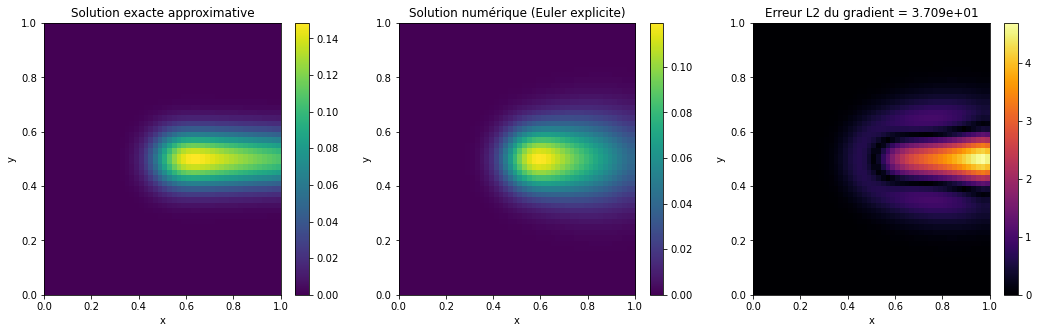

In [42]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.integrate import cumtrapz

# === Paramètres ===
L = 1.0
Nx = Ny = 50
dx = dy = L / (Nx-1)
x = np.linspace(0, L, Nx)
y = np.linspace(0, L, Ny)

Vx = 1.0
Vy = 0.0
nu = 0.01
lam = 1.0

Tc = 1.0
k = 100.0
xc, yc = 0.5, 0.5

# Condition initiale
u0 = np.zeros((Nx, Ny))

# Source
X, Y = np.meshgrid(x, y, indexing='ij')
f = Tc * np.exp(-k * ((X - xc)**2 + (Y - yc)**2))

# Pas de temps selon CFL
dt = 0.5 * min(dx / Vx, dx**2/(2*nu), dy**2/(2*nu))
T_final = 0.5
Nt = int(T_final / dt)

# === Simulation numérique (Euler explicite) ===
u = u0.copy()
u_new = np.zeros_like(u)

for n in range(Nt):
    u_new[1:-1,1:-1] = (
        u[1:-1,1:-1]
        - dt * Vx * (u[1:-1,1:-1] - u[0:-2,1:-1]) / dx
        - dt * Vy * (u[1:-1,1:-1] - u[1:-1,0:-2]) / dy
        + dt * nu * (
            (u[2:,1:-1] - 2*u[1:-1,1:-1] + u[0:-2,1:-1]) / dx**2 +
            (u[1:-1,2:] - 2*u[1:-1,1:-1] + u[1:-1,0:-2]) / dy**2
        )
        - dt * lam * u[1:-1,1:-1]
        + dt * f[1:-1,1:-1]
    )

    # Conditions aux limites
    u_new[0,:] = 0.0
    u_new[-1,:] = u_new[-2,:]
    u_new[:,0] = u_new[:,1]
    u_new[:,-1] = u_new[:,-2]

    u[:,:] = u_new[:,:]

# === Solution exacte approximative 1D en x pour chaque y ===
u_exact = np.zeros_like(u)
for j in range(Ny):
    integrand = f[:,j] * np.exp(lam * x / Vx)
    integral = cumtrapz(integrand, x, initial=0)
    u_exact[:,j] = np.exp(-lam * x / Vx) / Vx * integral

# === Affichage corrigé avec axes corrects ===
fig, axs = plt.subplots(1,3,figsize=(18,5))

im0 = axs[0].imshow(u_exact.T, extent=[0,L,0,L], origin='lower', cmap='viridis', aspect='auto')
axs[0].set_xlabel("x")
axs[0].set_ylabel("y")
axs[0].set_title("Solution exacte approximative")
plt.colorbar(im0, ax=axs[0])

im1 = axs[1].imshow(u.T, extent=[0,L,0,L], origin='lower', cmap='viridis', aspect='auto')
axs[1].set_xlabel("x")
axs[1].set_ylabel("y")
axs[1].set_title("Solution numérique (Euler explicite)")
plt.colorbar(im1, ax=axs[1])

gradx = (u - u_exact)/dx
grady = (u - u_exact)/dy
error_L2 = np.sqrt(np.sum(gradx**2 + grady**2))
im2 = axs[2].imshow(np.sqrt(gradx**2 + grady**2).T, extent=[0,L,0,L], origin='lower', cmap='inferno', aspect='auto')
axs[2].set_xlabel("x")
axs[2].set_ylabel("y")
axs[2].set_title(f"Erreur L2 du gradient = {error_L2:.3e}")
plt.colorbar(im2, ax=axs[2])

plt.show()



## Équation ADRS réduite à 1D

Supposons $u = u(x, t)$ et que le domaine soit :

- $x \in [0, L]$  
- $y \in \mathbb{R}$, mais $u$ ne dépend pas de $y$

L'équation 1D devient :

$$
\frac{\partial u}{\partial t} + V_x(x, t) \frac{\partial u}{\partial x} - \nu \frac{\partial^2 u}{\partial x^2} = -\lambda u + f(x, t)
$$

où :

- $u(x, t)$ : concentration ou quantité transportée  
- $V_x(x, t)$ : vitesse dans la direction $x$  
- $\nu$ : coefficient de diffusion  
- $\lambda$ : coefficient de réaction  
- $f(x, t)$ : source externe  

---

## Conditions typiques

- **Condition initiale** : $u(x, 0) = u_0(x)$  
- **Condition aux limites** :  
  - Dirichlet à gauche : $u(0, t) = g_0(t)$  
  - Neumann à droite : $\frac{\partial u}{\partial x}(L, t) = 0$ (par exemple flux nul)


## Résolution avec Euler explicite

### Domaine
- Longueur : $L = 1.0 \, \text{m}$
- Discrétisation : $N_x = 100$ points
- Pas spatial : $\Delta x = L / (N_x - 1)$

### Temps
- Temps final : $T_{\text{final}} = 0.5 \, \text{s}$
- Pas temporel : choisi selon CFL pour Euler explicite stable

### Vitesse et diffusion
- Vitesse : $V = 1.0 \, \text{m/s}$
- Coefficient de diffusion : $\nu = 0.01 \, \text{m}^2/\text{s}$
- Coefficient de réaction : $\lambda = 1.0 \, \text{s}^{-1}$

### Source
- Fonction : $f(x,t) = T_c \exp(-k (x-x_c)^2)$
- Paramètres :  
  - $T_c = 1.0$  
  - $k = 100.0$  
  - Centre de la source : $x_c = 0.5 \, \text{m}$

### Conditions initiales
- $u(x,0) = \sin(2\pi x / L)$

### Conditions aux limites
- Dirichlet à gauche : $u(0,t) = 0$
- Neumann à droite : $\frac{\partial u}{\partial x}(L,t) = 0$

### CFL pour Euler explicite
- $\Delta t \le \min \left(\frac{\Delta x}{V}, \frac{\Delta x^2}{2\nu}\right)$


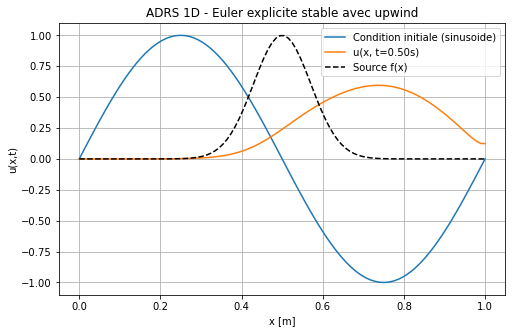

In [38]:
import numpy as np
import matplotlib.pyplot as plt

# === Paramètres ===
L = 1.0
Nx = 100
dx = L / (Nx-1)
x = np.linspace(0, L, Nx)

V = 1.0
nu = 0.01
lam = 1.0

Tc = 1.0
k = 100.0
xc = 0.5

# Condition initiale sinusoidale
u0 = np.sin(2*np.pi * x / L)

# Source
def f(x):
    return Tc * np.exp(-k * (x - xc)**2)

# Pas de temps selon CFL (sécurité)
dt = 0.5 * min(dx / V, dx**2 / (2*nu))
T_final = 0.5
Nt = int(T_final / dt)

# === Initialisation ===
u = u0.copy()
u_new = np.zeros_like(u)

# Stockage pour affichage
u_init = u0.copy()
source = f(x)

# === Boucle temporelle (Euler explicite + upwind) ===
for n in range(Nt):
    # Advection upwind, diffusion central
    u_new[1:-1] = (
        u[1:-1]
        - dt * V * (u[1:-1] - u[0:-2]) / dx      # upwind pour advection
        + dt * nu * (u[2:] - 2*u[1:-1] + u[0:-2]) / dx**2  # diffusion
        - dt * lam * u[1:-1]                     # réaction
        + dt * f(x[1:-1])                        # source
    )
    
    # Conditions aux limites
    u_new[0] = 0.0            # Dirichlet gauche
    u_new[-1] = u_new[-2]     # Neumann droite
    
    # Mise à jour
    u[:] = u_new[:]

# === Affichage ===
plt.figure(figsize=(8,5))
plt.plot(x, u_init, label="Condition initiale (sinusoide)")
plt.plot(x, u, label=f"u(x, t={T_final:.2f}s)")
plt.plot(x, source, 'k--', label="Source f(x)")
plt.xlabel("x [m]")
plt.ylabel("u(x,t)")
plt.legend()
plt.title("ADRS 1D - Euler explicite stable avec upwind")
plt.grid(True)
plt.show()

## Paramètres physiques et numériques pour la simulation ADRS 1D

### Domaine
- Longueur : $L = 1.0 \, \text{m}$
- Discrétisation : $N_x = 100$ points
- Pas spatial : $\Delta x = L / (N_x - 1)$

### Temps
- Temps final : $T_{\text{final}} = 0.5 \, \text{s}$
- Pas temporel : choisi selon CFL pour Euler explicite stable

### Vitesse et diffusion
- Vitesse : $V = 1.0 \, \text{m/s}$
- Coefficient de diffusion : $\nu = 0.01 \, \text{m}^2/\text{s}$
- Coefficient de réaction : $\lambda = 1.0 \, \text{s}^{-1}$

### Source
- Fonction : $f(x,t) = T_c \exp(-k (x-x_c)^2)$
- Paramètres :  
  - $T_c = 1.0$  
  - $k = 100.0$  
  - Centre de la source : $x_c = 0.5 \, \text{m}$

### Conditions initiales
- $u(x,0) = u_0(x)$ avec $u_0(0) = u_L$, et $\frac{\partial u_0}{\partial x}(L) = g$
- Exemple : $u_0(x) = u_L + (g * x) + \sin(2 \pi x / L)$

### Conditions aux limites
- Dirichlet gauche non homogène : $u(t,0) = u_L$
- Neumann droite non homogène : $\frac{\partial u}{\partial x}(t,L) = g$

### CFL pour Euler explicite
- $\Delta t \le \min \left(\frac{\Delta x}{V}, \frac{\Delta x^2}{2\nu}\right)$


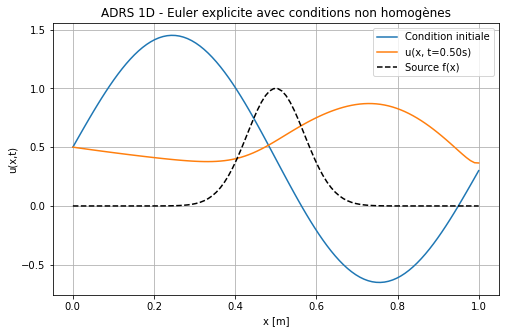

In [39]:
import numpy as np
import matplotlib.pyplot as plt

# === Paramètres ===
L = 1.0
Nx = 100
dx = L / (Nx-1)
x = np.linspace(0, L, Nx)

V = 1.0
nu = 0.01
lam = 1.0

Tc = 1.0
k = 100.0
xc = 0.5

# Conditions aux limites non homogènes
u_L = 0.5       # Dirichlet à gauche
g = -0.2        # Neumann à droite

# Condition initiale conforme aux limites
u0 = u_L + g * x + np.sin(2 * np.pi * x / L)  # u0(0)=u_L, u0_x(L)=g

# Source
def f(x):
    return Tc * np.exp(-k * (x - xc)**2)

# Pas de temps selon CFL
dt = 0.5 * min(dx / V, dx**2 / (2*nu))
T_final = 0.5
Nt = int(T_final / dt)

# === Initialisation ===
u = u0.copy()
u_new = np.zeros_like(u)

# Stockage pour affichage
u_init = u0.copy()
source = f(x)

# === Boucle temporelle (Euler explicite + upwind) ===
for n in range(Nt):
    # Advection upwind, diffusion central
    u_new[1:-1] = (
        u[1:-1]
        - dt * V * (u[1:-1] - u[0:-2]) / dx
        + dt * nu * (u[2:] - 2*u[1:-1] + u[0:-2]) / dx**2
        - dt * lam * u[1:-1]
        + dt * f(x[1:-1])
    )
    
    # Conditions aux limites non homogènes
    u_new[0] = u_L                  # Dirichlet gauche
    u_new[-1] = u_new[-2] + g*dx   # Neumann droite non homogène
    
    # Mise à jour
    u[:] = u_new[:]

# === Affichage ===
plt.figure(figsize=(8,5))
plt.plot(x, u_init, label="Condition initiale")
plt.plot(x, u, label=f"u(x, t={T_final:.2f}s)")
plt.plot(x, source, 'k--', label="Source f(x)")
plt.xlabel("x [m]")
plt.ylabel("u(x,t)")
plt.legend()
plt.title("ADRS 1D - Euler explicite avec conditions non homogènes")
plt.grid(True)
plt.show()


## Un dernier exemple avec l'évolution dans le temps d'une fonction de type indicatrice

In [ ]:
# Paramètres
L = 1.0
Nx = 100
dx = L/(Nx-1)
dt = 0.001
Nt = 500
nu = 0.01
lambda_ = 0.0

In [24]:
# Fonctions données
def V(t, s):
    return 1.0  # vitesse constante

def f(t, s):
    return 0.0  # source nulle

In [25]:
# Condition initiale : indicatrice sur [0,0.1]
def u0(s):
    return np.where((s >= 0) & (s <= 0.1), 1.0, 0.0)

ul = 1.0  # condition au bord gauche

In [26]:
# Discrétisation spatiale
s = np.linspace(0, L, Nx)
u = u0(s)

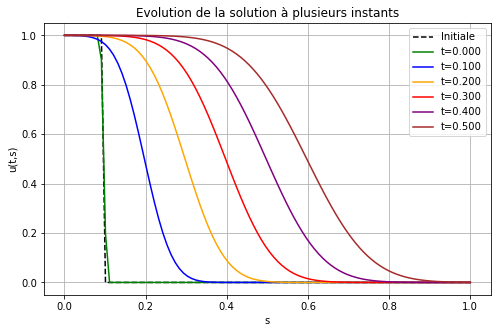

In [27]:
# Instants où on souhaite tracer la solution
times_to_plot = [0, 100, 200, 300, 400, 500]  # pas de temps
colors = ['green', 'blue', 'orange', 'red', 'purple', 'brown']

plt.figure(figsize=(8,5))

# Affichage de la condition initiale
plt.plot(s, u0(s), '--', color='black', label='Initiale')
for n in range(Nt+1):
    u_new = np.copy(u)
    
    # Intérieur du domaine : différences centrées pour uss et upwind pour us
    for i in range(1, Nx-1):
        us = (u[i] - u[i-1])/dx
        uss = (u[i+1] - 2*u[i] + u[i-1])/dx**2
        u_new[i] = u[i] + dt*(-V(n*dt, s[i])*us + nu*uss - lambda_*u[i] + f(n*dt, s[i]))
    
    # Conditions aux bords
    u_new[0] = ul
    u_new[-1] = u_new[-2]
    
    u = u_new
    
    # Tracer aux instants choisis
    if n in times_to_plot:
        plt.plot(s, u, label=f't={n*dt:.3f}', color=colors[times_to_plot.index(n)])

plt.xlabel('s')
plt.ylabel('u(t,s)')
plt.title('Evolution de la solution à plusieurs instants')
plt.legend()
plt.grid()
plt.show()

## Evaluation de la pertinence du schéma numérique :

On se donne une fonction gaussienne $u_{\text{exact}}(x) = \exp\left(-\frac{(x - s_0)^2}{2 \sigma^2}\right)$ comme solution exacte et on cherche la source à imposer pour obtenir la bonne solution. On réinjecte la source dans l'équation et on résoud l'équation via Euler explicite. On évalue la pertinence du schéma en observant l'erreur entre la solution exacte et la solution numérique.

### Dans un premier temps, le schéma stationnaire

dt = 0.00101, NT = 4950
Erreur relative L2 : 0.016120


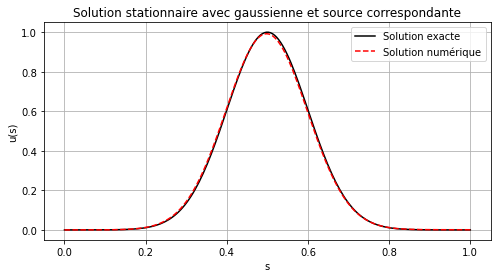

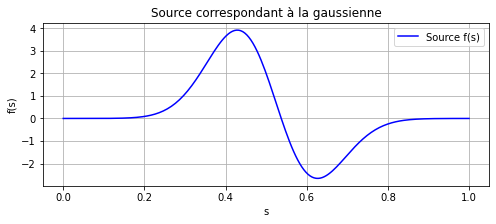

In [43]:
# ---------------- Paramètres physiques ----------------
L = 1.0        # longueur du domaine
NX = 200       # nombre de points
V = 0.5        # vitesse d'advection
nu = 0.01      # diffusion
lamda = 1.0    # réaction

# Grille spatiale
x = np.linspace(0, L, NX)
dx = x[1] - x[0]
# ---------------- Solution exacte : gaussienne centrée ----------------
s0 = 0.5 * L
sigma = 0.1 * L
u_exact = np.exp(-(x - s0)**2 / (2*sigma**2))

# Dérivées pour calculer la source
u_s = np.gradient(u_exact, dx)
u_ss = np.gradient(u_s, dx)

# Source pour que u_exact soit solution stationnaire
f = V * u_s - nu * u_ss + lamda * u_exact

# Conditions aux limites
ul = 0.0
u_exact[0] = ul          # Dirichlet gauche
u_exact[-1] = u_exact[-2] # Neumann droite

# ---------------- Schéma explicite pour solution numérique ----------------
# Calcul du pas de temps stable (CFL)
dt_advection = dx / V
dt_diffusion = dx**2 / (2*nu)
dt_reaction = 1 / lamda
dt = 0.8 * min(dt_advection, dt_diffusion, dt_reaction)
Tmax = 5.0
NT = int(Tmax/dt)
print(f"dt = {dt:.5f}, NT = {NT}")

# Initialisation
u = np.zeros_like(x)
u[0] = ul  # condition Dirichlet
u[1:] = 0.0

# Boucle temporelle
for n in range(NT):
    u_xx = np.zeros_like(u)
    u_xx[1:-1] = (u[2:] - 2*u[1:-1] + u[0:-2]) / dx**2
    
    u_x = np.zeros_like(u)
    u_x[1:] = (u[1:] - u[:-1]) / dx
    
    # Mise à jour
    u[1:-1] = u[1:-1] + dt * (-V*u_x[1:-1] + nu*u_xx[1:-1] - lamda*u[1:-1] + f[1:-1])
    
    # Conditions aux limites
    u[0] = ul
    u[-1] = u[-2]

    # ---------------- Calcul de l'erreur ----------------
error = np.linalg.norm(u - u_exact, ord=2) / np.linalg.norm(u_exact, ord=2)
print(f"Erreur relative L2 : {error:.6f}")

# ---------------- Affichage ----------------
plt.figure(figsize=(8,4))
plt.plot(x, u_exact, 'k-', label='Solution exacte')
plt.plot(x, u, 'r--', label='Solution numérique')
plt.xlabel('s')
plt.ylabel('u(s)')
plt.title('Solution stationnaire avec gaussienne et source correspondante')
plt.legend()
plt.grid(True)
plt.show()

# Affichage de la source
plt.figure(figsize=(8,3))
plt.plot(x, f, 'b', label='Source f(s)')
plt.xlabel('s')
plt.ylabel('f(s)')
plt.title('Source correspondant à la gaussienne')
plt.grid(True)
plt.legend()
plt.show()

## Description du code

### Objectif
Ce code résout numériquement l'équation d'Advection-Diffusion-Réaction-Sourcée (ADRS) 1D. Il utilise des méthodes de différences finies pour simuler l'évolution temporelle d'une variable \( T(x,t) \), qui pourrait représenter la température, la concentration ou une autre quantité physique. Le modèle inclut les termes de diffusion, advection, réaction et source.

### Paramètres physiques
- **K** : Coefficient de diffusion.
- **L** : Taille du domaine spatial (1.0).
- **V** : Vitesse d'advection.
- **lamda** : Coefficient de réaction.
  
### Paramètres numériques
- **NX** : Nombre initial de points sur la grille spatiale.
- **NT** : Nombre maximal de pas de temps.
- **eps** : Critère de convergence relatif pour arrêter les itérations.
- **niter_refinement** : Nombre d'itérations avec un raffinement progressif du maillage.

### Étapes du calcul

1. **Initialisation**
   - Le domaine spatial \( x \) est discretisé en **NX** points.
   - La condition initiale \( T(x,0) \) est donnée par une fonction sinus pour chaque itération de raffinement du maillage.
   - Le terme source \( F(x) \) est calculé à partir de la dérivée spatiale de la solution.

2. **Calcul des pas de maillage et de temps**
   - Le pas spatial \( dx \) et le pas temporel \( dt \) sont calculés selon les conditions de stabilité de Courant-Friedrichs-Lewy (CFL). Le pas temporel est ajusté en fonction de la diffusion et de la source.

3. **Boucle temporelle**
   - À chaque itération temporelle, la solution \( T(x,t) \) est mise à jour en résolvant l'équation discrétisée.
   - Les termes de l'équation sont calculés et les nouvelles valeurs de \( T \) sont stockées.
   - Le résidu est calculé à chaque itération pour mesurer l'erreur relative. L'itération s'arrête lorsque le résidu devient suffisamment petit, ce qui signifie que la solution a convergé.

4. **Affichage graphique**
   - Le graphique de la solution \( T(x,t) \) est tracé pour chaque pas de temps où le résidu est suffisamment faible.
   - Un autre graphique montre la convergence des résidus au fil des itérations, avec un affichage du logarithme des résidus.

5. **Calcul des erreurs**
   - L'erreur de la solution est calculée en comparant la solution numérique avec la solution exacte \( T_{exact}(x) \), qui est une fonction sinus.
   - L'erreur H1 est également calculée en fonction de la dérivée de \( T \).

### Résultats
- Le code génère des graphiques montrant l'évolution de la variable \( T(x,t) \) au cours du temps.
- Il affiche également l'évolution des erreurs à chaque raffinement du maillage, permettant d'évaluer la précision de la solution numérique.

### Améliorations possibles
- Le code peut être optimisé en ajustant la gestion des itérations et des raffinements du maillage.
- Il serait utile de réactiver les axes et légendes dans les graphiques pour une meilleure lisibilité.



0.25 0.15151515151515152
15 0.0008080951539148969
15 0.0008080951539148969
norm error= 0.6233688194842221
0.14285714285714285 0.07751937984496124
32 0.001029090643382475
32 0.001029090643382475
norm error= 0.639569241938036
0.1 0.04761904761904762
53 0.001057303593346724
53 0.001057303593346724
norm error= 0.5875174434210193
0.07692307692307693 0.03236245954692557
79 0.0010210162429683373
79 0.0010210162429683373
norm error= 0.5388314660980307
0.0625 0.023474178403755867
111 0.0009452711616317739
111 0.0009452711616317739
norm error= 0.4988361784087069
0.05263157894736842 0.017825311942959
148 0.0008865003637870918
148 0.0008865003637870918
norm error= 0.46613855542737204
0.045454545454545456 0.01400560224089636
191 0.0008115824810071939
191 0.0008115824810071939
norm error= 0.43894835326870096
0.04 0.011299435028248588
239 0.0007611782960256818
239 0.0007611782960256818
norm error= 0.4160093981227173
0.03571428571428571 0.009310986964618248
293 0.000706321602626096
293 0.0007063216026

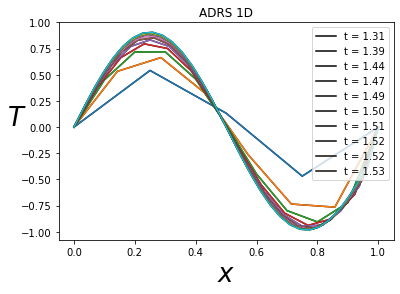

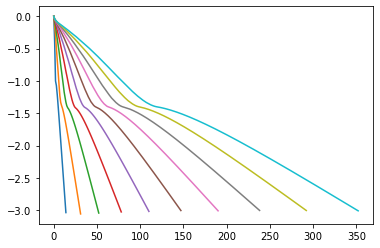

In [5]:
import math
import numpy as np
import matplotlib.pyplot as plt

#u,t = -V u,x + k u,xx  -lamda u + f

# PHYSICAL PARAMETERS
K = 0.1     #Diffusion coefficient
L = 1.0     #Domain size
Time = 20.  #Integration time


V=1
lamda=1

# NUMERICAL PARAMETERS
NX = 2  #Number of grid points
NT = 10000   #Number of time steps max
ifre=1000000  #plot every ifre time iterations
eps=0.001     #relative convergence ratio
niter_refinement=10      #niter different calculations with variable mesh size

error=np.zeros((niter_refinement))

for iter in range (niter_refinement):
    NX=NX+3

    dx = L/(NX-1)                 #Grid step (space)
    dt = dx**2/(V*dx+K+dx**2)   #Grid step (time)  condition CFL de stabilite 10.4.5
    print(dx,dt)

    ### MAIN PROGRAM ###

    # Initialisation
    x = np.linspace(0.0,1.0,NX)
    T = np.zeros((NX)) #np.sin(2*np.pi*x)
    F = np.zeros((NX))
    rest = []
    RHS = np.zeros((NX))

    Tex = np.zeros((NX)) #np.sin(2*np.pi*x)
    Texx = np.zeros((NX)) #np.sin(2*np.pi*x)
    for j in range (1,NX-1):
        Tex[j] = np.sin(2*j*math.pi/NX)
    for j in range (1,NX-1):
        Texx[j]=(Tex[j+1]-Tex[j-1])/(2*dx)  #np.cos(j*math.pi/NX)*math.pi/NX  
        Txx=(Tex[j+1]-2*Tex[j]+Tex[j-1])/(dx**2)  #-np.sin(j*math.pi/NX)*(math.pi/NX)**2    #
        F[j]=V*Texx[j]-K*Txx+lamda*Tex[j]
        
        
    dt = dx**2/(V*dx+2*K+abs(np.max(F))*dx**2)   #Grid step (time)  condition CFL de stabilite 10.4.5

    plt.figure(1)


    # Main loop en temps
    #for n in range(0,NT):
    n=0
    res=1
    res0=1
    while(n<NT and res/res0>eps):
        n+=1
    #discretization of the advection/diffusion/reaction/source equation
        res=0
        for j in range (1, NX-1):
            xnu=K+0.5*dx*abs(V) 
            Tx=(T[j+1]-T[j-1])/(2*dx)
            Txx=(T[j-1]-2*T[j]+T[j+1])/(dx**2)
            RHS[j] = dt*(-V*Tx+xnu*Txx-lamda*T[j]+F[j])
            res+=abs(RHS[j])

        for j in range (1, NX-1):
            T[j] += RHS[j]
            RHS[j]=0


        if (n == 1 ):
            res0=res

        rest.append(res)
    #Plot every ifre time steps
        if (n%ifre == 0 or (res/res0)<eps):
            print(n,res)
            plotlabel = "t = %1.2f" %(n * dt)
            plt.plot(x,T, label=plotlabel,color = plt.get_cmap('copper')(float(n)/NT))
          

    print(n,res)
    plt.plot(x,T)

    plt.xlabel(u'$x$', fontsize=26)
    plt.ylabel(u'$T$', fontsize=26, rotation=0)
    plt.title(u'ADRS 1D')
    plt.legend()

    plt.figure(2)
    plt.plot(np.log10(rest/rest[0]))

    err=np.dot(T-Tex,T-Tex)
    errh1=0
    for j in range (1,NX-1):
        errh1+=(Texx[j]-(T[j+1]-T[j-1])/(2*dx))**2
       
    error[iter]=np.sqrt(err)
    print('norm error=',error[iter])


# plt.figure(3)
# plt.plot(x,Tex, label=plotlabel,color = plt.get_cmap('copper')(float(n)/NT))



## Identification des parties du code

### 1. Décalage = centre + viscosité numérique (chapitre 12)
Cela correspond à l’ajout d’un terme de **viscosité numérique** pour stabiliser le schéma.
Dans le code, on le retrouve ici :
```python
xnu = K + 0.5*dx*abs(V) 
Tx = (T[j+1]-T[j-1])/(2*dx)
Txx = (T[j-1]-2*T[j]+T[j+1])/(dx**2)
RHS[j] = dt*(-V*Tx + xnu*Txx - lamda*T[j] + F[j])


## 2. Condition de stabilité CFL (chapitre 10)
Le pas de temps `dt` est calculé en respectant la condition de stabilité CFL.  
On le voit dans deux endroits du code :

```python
dt = dx**2/(V*dx + K + dx**2)   # premier calcul
...
dt = dx**2/(V*dx + 2*K + abs(np.max(F))*dx**2)  # après calcul de la source


## 3. Marche en temps vers la solution stationnaire
La résolution se fait par une boucle temporelle qui met à jour la solution jusqu’à atteindre un état stationnaire :

```python
n = 0
res = 1
res0 = 1
while (n < NT and res/res0 > eps):
    n += 1
    ...
    T[j] += RHS[j]


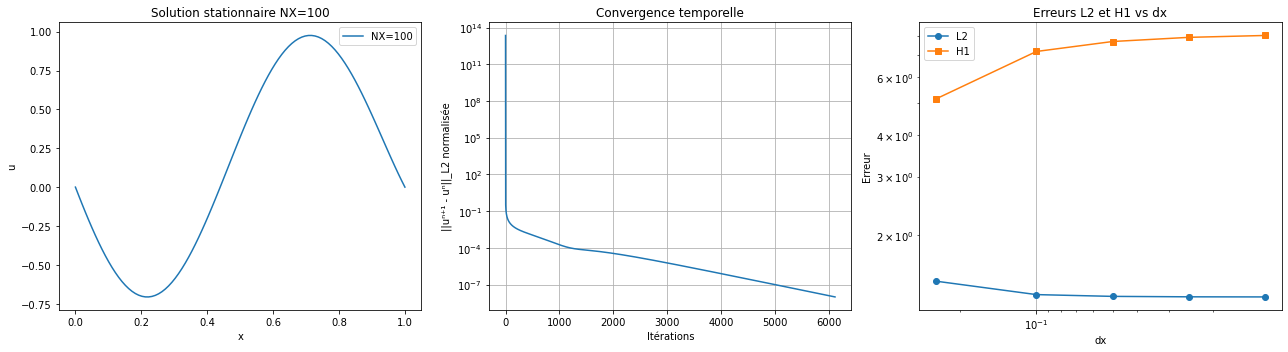

In [1]:
import numpy as np
import matplotlib.pyplot as plt

# =======================
# Paramètres physiques
# =======================
K = 0.1
L = 1.0
V = 1.0
lamda = 1.0

# =======================
# Paramètres numériques
# =======================
NT_max = 100000
eps = 1e-8
niter_refinement = 5
NX_stationary = 100

# =======================
# Solution exacte et dérivées
# =======================
def u_exact(x):
    return np.sin(2*np.pi*x)
def u_exact_dx(x):
    return 2*np.pi*np.cos(2*np.pi*x)

# =======================
# Convergence pour NX = 100
# =======================
dx = L/(NX_stationary-1)
dt = 0.5*dx**2/(K + V*dx)
x_stationary = np.linspace(0,L,NX_stationary)
T_stationary = np.zeros(NX_stationary)
Tex_stationary = u_exact(x_stationary)
Tex_dx_stationary = u_exact_dx(x_stationary)

# Source pour que solution exacte soit stationnaire
F_stationary = -V*Tex_dx_stationary + K*((np.roll(Tex_stationary,-1)-2*Tex_stationary+np.roll(Tex_stationary,1))/dx**2) + lamda*Tex_stationary
F_stationary[0] = F_stationary[-1] = 0

res = 1.0
T_old = T_stationary.copy()
conv_list = []
n = 0
while n < NT_max and res > eps:
    n += 1
    RHS = np.zeros(NX_stationary)
    for j in range(1,NX_stationary-1):
        Tx = (T_stationary[j+1]-T_stationary[j-1])/(2*dx)
        Txx = (T_stationary[j-1]-2*T_stationary[j]+T_stationary[j+1])/dx**2
        RHS[j] = dt*(-V*Tx + K*Txx - lamda*T_stationary[j] + F_stationary[j])
    T_stationary[1:-1] += RHS[1:-1]
    T_stationary[0] = 0
    T_stationary[-1] = 0
    res = np.linalg.norm(T_stationary-T_old)/np.linalg.norm(T_old+1e-16)
    conv_list.append(res)
    T_old[:] = T_stationary[:]

# =======================
# Boucle sur 5 maillages plus grands
# =======================
error_L2 = []
error_H1 = []
dx_list = []

NX_list = [5, 11, 21, 41, 81]  # maillages progressifs

for NX in NX_list:
    dx = L/(NX-1)
    dx_list.append(dx)
    dt = 0.5*dx**2/(K + V*dx)

    x = np.linspace(0,L,NX)
    T = np.zeros(NX)
    Tex = u_exact(x)
    Tex_dx = u_exact_dx(x)
    F = -V*Tex_dx + K*((np.roll(Tex,-1)-2*Tex+np.roll(Tex,1))/dx**2) + lamda*Tex
    F[0] = F[-1] = 0

    res = 1.0
    T_old = T.copy()
    n = 0
    while n < NT_max and res > eps:
        n += 1
        RHS = np.zeros(NX)
        for j in range(1,NX-1):
            Tx = (T[j+1]-T[j-1])/(2*dx)
            Txx = (T[j-1]-2*T[j]+T[j+1])/dx**2
            RHS[j] = dt*(-V*Tx + K*Txx - lamda*T[j] + F[j])
        T[1:-1] += RHS[1:-1]
        T[0] = 0
        T[-1] = 0
        res = np.linalg.norm(T-T_old)/np.linalg.norm(T_old+1e-16)
        T_old[:] = T[:]

    err_L2 = np.sqrt(np.sum((T-Tex)**2)*dx)
    err_H1 = np.sqrt(np.sum(((T[2:]-T[:-2])/(2*dx) - Tex_dx[1:-1])**2)*dx)
    error_L2.append(err_L2)
    error_H1.append(err_H1)

# =======================
# Affichage des résultats
# =======================
plt.figure(figsize=(18,5))

# Solution stationnaire NX=100
plt.subplot(1,3,1)
plt.plot(x_stationary, T_stationary, label=f"NX={NX_stationary}")
plt.title("Solution stationnaire NX=100")
plt.xlabel("x")
plt.ylabel("u")
plt.legend()

# Convergence temporelle NX=100
plt.subplot(1,3,2)
plt.semilogy(conv_list)
plt.title("Convergence temporelle")
plt.xlabel("Itérations")
plt.ylabel("||uⁿ⁺¹ - uⁿ||_L2 normalisée")
plt.grid(True)

# Erreurs L2 et H1 vs dx
plt.subplot(1,3,3)
plt.loglog(dx_list,error_L2,'o-',label='L2')
plt.loglog(dx_list,error_H1,'s-',label='H1')
plt.gca().invert_xaxis()
plt.title("Erreurs L2 et H1 vs dx")
plt.xlabel("dx")
plt.ylabel("Erreur")
plt.grid(True)
plt.legend()

plt.tight_layout()
plt.show()


## Explication du code et des calculs réalisés

### 1. Convergence vers la solution stationnaire (NX = 100)
- On crée un maillage fin de 100 points sur le domaine `[0,L]`.
- La solution exacte est définie par `u_exact(x) = sin(2πx)` et sa dérivée `u_exact_dx(x)`.
- On calcule la source `F_stationary` de manière à ce que cette solution exacte soit stationnaire pour l'équation ADRS.
- La solution `T_stationary` est initialisée à zéro et évolue dans le temps jusqu'à ce que la **norme relative de variation** entre deux itérations consécutives soit inférieure à `eps`.
- Les valeurs aux bords sont fixées à zéro (`Dirichlet homogène`) pour `x=0` et `x=L`.
- La convergence temporelle est enregistrée dans `conv_list` pour tracer `||uⁿ⁺¹ - uⁿ||_L2` normalisée.

### 2. Étude des erreurs pour différents maillages
- On définit 5 maillages progressifs : `[5, 11, 21, 41, 81]`.
- Pour chaque maillage :
  - On initialise la solution à zéro et on calcule la source `F` pour correspondre à la solution exacte.
  - La solution évolue dans le temps jusqu'à convergence stationnaire (critère `eps`).
  - Après convergence, on calcule :
    - L'erreur **L2** : `||T - Tex||_L2`.
    - L'erreur **H1** : `||∂T/∂x - ∂Tex/∂x||_L2`.
  - Ces erreurs sont stockées pour chaque maillage et tracées en fonction du pas `dx`.

### 3. Tracés réalisés
- Figure 1 : **Solution stationnaire pour NX=100**.
- Figure 2 : **Convergence temporelle** de NX=100 (`||uⁿ⁺¹ - uⁿ||_L2` normalisée en fonction des itérations).
- Figure 3 : **Erreurs L2 et H1 en fonction de dx** pour les 5 maillages, tracé en échelle log-log.
  - L'axe des abscisses est inversé pour mieux visualiser la convergence vers des maillages plus fins.
  - Les légendes permettent de distinguer L2 et H1.

### 4. Points clés
- La séparation claire entre le maillage fin (NX=100) pour convergence stationnaire et les petits maillages pour étude d’erreur évite les erreurs de dimension lors des tracés.
- La méthode explicite est utilisée pour l’évolution temporelle avec un pas `dt` choisi en fonction de la **stabilité CFL**.
- Les conditions de Dirichlet homogènes sont appliquées aux bords pour toutes les simulations.
- L'étude des erreurs L2 et H1 permet de vérifier la **convergence numérique** lorsque le maillage est raffiné.


0.07142857142857142 0.010706638115631691
157 0.0003459740491735962
157 0.0003459740491735962
norm error L2, H1= 0.003701364871997212 0.1329053415378006
0.05263157894736842 0.00608272506082725
276 0.0002813468456662959
276 0.0002813468456662959
norm error L2, H1= 0.002101933726478024 0.08279624510830823
0.041666666666666664 0.003915426781519185
429 0.00023109697981142977
429 0.00023109697981142977
norm error L2, H1= 0.001356377436137919 0.05584131395305104
0.034482758620689655 0.002729257641921397
615 0.00019640013125502627
615 0.00019640013125502627
norm error L2, H1= 0.0009492036046260966 0.04002820924313445
0.029411764705882353 0.002010454362685967
835 0.00016940778293841755
835 0.00016940778293841755
norm error L2, H1= 0.0007022182931158395 0.030038914795086313
0.02564102564102564 0.0015422578655151138
1087 0.00015028459472351394
1087 0.00015028459472351394
norm error L2, H1= 0.0005413982008868348 0.023355017683043537
0.022727272727272728 0.00122040517451794
1372 0.00013503891334534

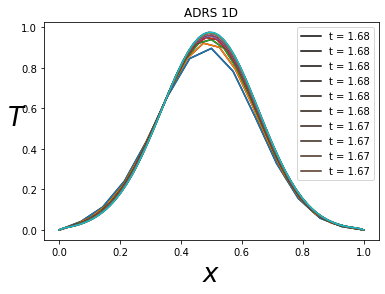

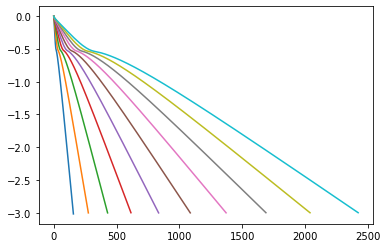

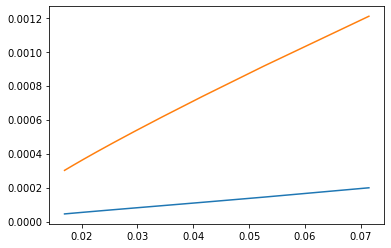

In [5]:
import math
import numpy as np
import matplotlib.pyplot as plt

#u,t = -V u,x + k u,xx  -lamda u + f

# PHYSICAL PARAMETERS
K = 0.1     #Diffusion coefficient
L = 1.0     #Domain size
Time = 20.  #Integration time


V=1
lamda=1

# NUMERICAL PARAMETERS
NX = 10    #Number of grid points
NT = 10000   #Number of time steps max
ifre=1000000  #plot every ifre time iterations
eps=0.001     #relative convergence ratio
niter_refinement=10      #niter different calculations

errorL2=np.zeros((niter_refinement))
errorH1=np.zeros((niter_refinement))
semiH2=np.zeros((niter_refinement))
itertab=np.zeros((niter_refinement))

for iter in range (niter_refinement):
	NX=NX+5

	dx = L/(NX-1)                 #Grid step (space)
	dt = dx**2/(V*dx+4*K+dx**2)   #Grid step (time)  condition CFL de stabilite 10.4.5
	print(dx,dt)
	itertab[iter]=dx

	### MAIN PROGRAM ###

	# Initialisation
	x = np.linspace(0.0,1.0,NX)
	T = np.zeros((NX)) #np.sin(2*np.pi*x)
	F = np.zeros((NX))
	rest = []
	RHS = np.zeros((NX))

	Tex = np.zeros((NX)) #np.sin(2*np.pi*x)
	for j in range (1,NX-1):
		Tex[j] = np.exp(-20*(j*dx-0.5)**2)
	for j in range (1,NX-1):
		Tx=(Tex[j+1]-Tex[j-1])/(2*dx)
		Txx=(Tex[j+1]-2*Tex[j]+Tex[j-1])/(dx**2)
		F[j]=V*Tx-K*Txx+lamda*Tex[j]
		

	plt.figure(1)


	# Main loop en temps
	#for n in range(0,NT):
	n=0
	res=1
	res0=1
	while(n<NT and res/res0>eps):
		n+=1
	#discretization of the advection/diffusion/reaction/source equation
		res=0
		for j in range (1, NX-1):
			xnu=K+0.5*dx*abs(V) 
			Tx=(T[j+1]-T[j-1])/(2*dx)
			Txx=(T[j-1]-2*T[j]+T[j+1])/(dx**2)
			RHS[j] = dt*(-V*Tx+xnu*Txx-lamda*T[j]+F[j])
			res+=abs(RHS[j])

		for j in range (1, NX-1):
			T[j] += RHS[j]
			RHS[j]=0


		if (n == 1 ):
			res0=res

		rest.append(res)
	#Plot every ifre time steps
		if (n%ifre == 0 or (res/res0)<eps):
			print(n,res)
			plotlabel = "t = %1.2f" %(n * dt)
			plt.plot(x,T, label=plotlabel,color = plt.get_cmap('copper')(float(n)/NT))
		  

	print(n,res)
	plt.plot(x,T)

	plt.xlabel(u'$x$', fontsize=26)
	plt.ylabel(u'$T$', fontsize=26, rotation=0)
	plt.title(u'ADRS 1D')
	plt.legend()

	plt.figure(2)
	plt.plot(np.log10(rest/rest[0]))


#	errL2=np.sqrt(np.dot(T-Tex,T-Tex))
	errH1h=0
	errL2h=0
	semih2=0
	for j in range (1, NX-1):
		Texx=(Tex[j+1]-Tex[j-1])/(2*dx)
		Tx=(T[j+1]-T[j-1])/(2*dx)
		errL2h+=dx*(T[j]-Tex[j])**2
		errH1h+=dx*(Tx-Texx)**2
		Txx=(Tex[j+1]-2*Tex[j]+Tex[j-1])/(dx**2)
		semih2+=dx*Txx**2

	errorL2[iter]=errL2h
	errorH1[iter]=errL2h+errH1h
	semiH2[iter]=semih2
	
	
	print('norm error L2, H1=',errL2h,errH1h)


plt.figure(3)
#plt.plot(itertab,np.log10(errorL2),itertab,np.log10(errorH1))

plt.plot(itertab,np.sqrt(errorL2)/semiH2,itertab,np.sqrt(errorH1)/semiH2)



plt.show()


## Description du code

### 1. Objectif général
Ce code résout numériquement une équation d’**advection-diffusion-réaction avec source (ADRS)** en 1D sur le domaine `[0, L]` avec conditions aux bords homogènes. Il évalue la convergence temporelle vers une solution stationnaire et calcule les **erreurs numériques** par rapport à une solution exacte donnée.

### 2. Paramètres physiques et numériques
- **Physiques :**
  - `K = 0.1` : coefficient de diffusion.
  - `V = 1` : vitesse d’advection.
  - `lamda = 1` : coefficient de réaction.
  - Domaine : `L = 1.0`.
  - Temps de simulation maximal : `Time = 20`.
  
- **Numériques :**
  - `NX` : nombre initial de points du maillage.
  - `NT` : nombre maximal de pas de temps.
  - `dt` calculé selon la **condition de stabilité CFL**.
  - `eps` : critère de convergence pour la solution stationnaire.
  - `niter_refinement` : nombre de raffinement de maillage.

### 3. Construction de la solution exacte et source
- La solution exacte est une **gaussienne centrée en 0.5** : `Tex[j] = exp(-20*(j*dx-0.5)**2)`.
- La source `F[j]` est calculée pour rendre la solution exacte stationnaire :
  \[
  F_j = V \frac{dTex}{dx} - K \frac{d^2 Tex}{dx^2} + \lambda Tex_j
  \]

### 4. Boucle principale en temps
- La solution `T` est initialisée à zéro et évolue selon le schéma explicite :
  $
  T^{n+1}_j = T^n_j + dt \big(-V T_x + xnu T_{xx} - \lambda T_j + F_j \big)
  $
  avec `xnu = K + 0.5*dx*|V|` pour inclure un terme de viscosité numérique.
- La convergence est surveillée via la **norme L1 relative** des incréments `RHS`.
- Les résultats sont tracés tous les `ifre` pas ou lorsque la convergence est atteinte.

### 5. Calcul des erreurs
Pour chaque maillage raffiné :
- **Erreur L2** : 
  $
  \text{errL2h} = \sum_j dx (T_j - Tex_j)^2
  $
- **Erreur H1** :
  $
  \text{errH1h} = \sum_j dx \big( \frac{dT}{dx} - \frac{dTex}{dx} \big)^2
  $
- **Semi-norme H2** de la solution exacte :
  $
  \text{semih2} = \sum_j dx \big( \frac{d^2 Tex}{dx^2} \big)^2
 $
- Les erreurs L2 et H1 sont normalisées par `semiH2` pour tracer la convergence en fonction du pas de maillage `dx`.

### 6. Raffinement du maillage
- On réalise `niter_refinement = 10` simulations avec des maillages de plus en plus fins (`NX += 5` à chaque itération).
- Pour chaque raffinement, on calcule les erreurs normalisées et on les stocke dans `errorL2`, `errorH1`, et `semiH2`.

### 7. Tracés
1. **Figure 1** : solution stationnaire `T` pour chaque maillage et comparaison avec la solution exacte.
2. **Figure 2** : convergence temporelle `log10(res/res0)` pour visualiser la marche vers la solution stationnaire.
3. **Figure 3** : erreurs L2 et H1 normalisées par `semiH2` en fonction de `dx` pour tous les maillages.


## Consignes à appliquer et leur traduction dans le code ADRS_multiple_mesh.py

1. **Évaluer les normes des différences du polynôme sur différents maillages**  
   - Pour chaque maillage raffiné, calculer :  
     - La **norme L2** de la différence entre la solution numérique `u_h` et la solution exacte `u`.  
     - La **norme H1** de la différence entre les dérivées approchées `du_h/dx` et `du/dx`.  
     - La **semi-norme H2** de la solution exacte : intégrale discrète de `d²u/dx²`².  
   - Comparer également la solution exacte avec son interpolation **linéaire P1** sur le maillage pour évaluer l’erreur d’interpolation.

2. **Sauvegarder les normes pour chaque `dx`**  
   - Stocker les valeurs dans des tableaux `errorL2`, `errorH1`, `semiH2` en fonction du pas `dx`.

3. **Identifier (C,k) par optimisation pour trouver l’ordre en espace**  
   - On modélise l’erreur en L2 comme `C * dx^k`.  
   - Utiliser un **algorithme d’optimisation ou de régression linéaire sur log-log** pour identifier la constante `C` et l’ordre `k`.  
   - La pente `k` correspond à l’ordre en espace du schéma.

4. **Tracer les courbes pour visualiser l’ordre**  
   - Une fois `C` et `k` trouvés, superposer les courbes :  
     - `C * dx^(k+1)`  
     - `C * dx^k`  
     - `||u - u_h||_{L2} / ||u||_{H2}`  
   - L’objectif est de vérifier si la convergence observée correspond à l’ordre théorique attendu.

5. **Déterminer l’ordre en espace du code**  
   - L’ordre `k` issu de la régression/log-log de `||u - u_h||_L2` en fonction de `dx` donne l’ordre spatial effectif.

6. **Plan pour le code**  
   - Ajouter une fonction pour interpoler `u_exact` sur le maillage P1.  
   - Calculer et sauvegarder toutes les normes.  
   - Ajouter un bloc d’optimisation sur log-log pour identifier `C` et `k`.  
   - Tracer toutes les courbes côte à côte avec labels et légendes claires.


Ordre estimé k = 0.89, constante C = 6.527e-01


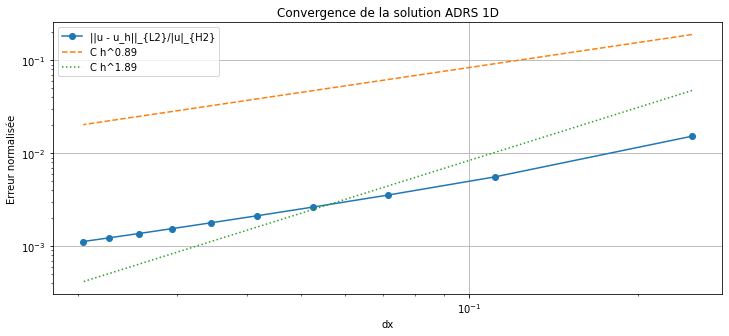

In [4]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.optimize import curve_fit

# --- Paramètres physiques ---
K = 0.1     # Diffusion
V = 1.0     # Advection
lamda = 1.0 # Réaction
L = 1.0     # Domaine

# --- Paramètres numériques ---
NX0 = 5               # Nombre initial de points
niter_refinement = 10  # Nombre de raffinement
NT = 10000
eps = 1e-3            # Critère convergence
Time = 20.0

# --- Tableaux pour stocker résultats ---
dx_tab = []
errorL2 = []
errorH1 = []
semiH2 = []

# Fonction modèle pour régression log-log : err ~ C * h^k
def model_func(h, C, k):
    return C * h**k

# --- Boucle sur les maillages ---
for it in range(niter_refinement):
    NX = NX0 + it * 5
    dx = L / (NX - 1)
    dt = dx**2 / (V*dx + 4*K + dx**2)  # CFL
    dx_tab.append(dx)

    # --- Initialisation ---
    x = np.linspace(0, L, NX)
    T = np.zeros(NX)
    F = np.zeros(NX)

    # --- Solution exacte gaussienne ---
    Tex = np.exp(-20*(x - 0.5)**2)

    # --- Calcul de la source F pour que Tex soit stationnaire ---
    Tx = np.zeros(NX)
    Txx = np.zeros(NX)
    for j in range(1, NX-1):
        Tx[j] = (Tex[j+1]-Tex[j-1])/(2*dx)
        Txx[j] = (Tex[j+1]-2*Tex[j]+Tex[j-1])/(dx**2)
        F[j] = V*Tx[j] - K*Txx[j] + lamda*Tex[j]

    # --- Boucle temporelle vers solution stationnaire ---
    res = 1
    res0 = 1
    n = 0
    while n < NT and res/res0 > eps:
        n += 1
        res = 0
        for j in range(1, NX-1):
            xnu = K + 0.5*dx*abs(V)
            Tx_j = (T[j+1]-T[j-1])/(2*dx)
            Txx_j = (T[j-1]-2*T[j]+T[j+1])/(dx**2)
            RHS = dt * (-V*Tx_j + xnu*Txx_j - lamda*T[j] + F[j])
            T[j] += RHS
            res += abs(RHS)
        if n == 1:
            res0 = res

    # --- Calcul des normes ---
    errL2h = 0.0
    errH1h = 0.0
    semih2 = 0.0
    for j in range(1, NX-1):
        Tx_num = (T[j+1]-T[j-1])/(2*dx)
        Tx_ex = (Tex[j+1]-Tex[j-1])/(2*dx)
        Txx_ex = (Tex[j+1]-2*Tex[j]+Tex[j-1])/(dx**2)
        errL2h += dx * (T[j]-Tex[j])**2
        errH1h += dx * (Tx_num - Tx_ex)**2
        semih2 += dx * Txx_ex**2

    errorL2.append(np.sqrt(errL2h))
    errorH1.append(np.sqrt(errL2h + errH1h))
    semiH2.append(np.sqrt(semih2))

# --- Conversion en arrays ---
dx_tab = np.array(dx_tab)
errorL2 = np.array(errorL2)
errorH1 = np.array(errorH1)
semiH2 = np.array(semiH2)

# --- Estimation de l'ordre en espace par régression log-log ---
popt, _ = curve_fit(model_func, dx_tab, errorL2)
C_opt, k_opt = popt
print(f"Ordre estimé k = {k_opt:.2f}, constante C = {C_opt:.3e}")

# --- Tracés ---
plt.figure(figsize=(12,5))

# Courbes d'erreur normalisée
plt.loglog(dx_tab, errorL2/semiH2, 'o-', label='||u - u_h||_{L2}/|u|_{H2}')
plt.loglog(dx_tab, C_opt*dx_tab**k_opt, '--', label=f'C h^{k_opt:.2f}')
plt.loglog(dx_tab, C_opt*dx_tab**(k_opt+1), ':', label=f'C h^{k_opt+1:.2f}')

plt.xlabel('dx')
plt.ylabel('Erreur normalisée')
plt.title('Convergence de la solution ADRS 1D')
plt.legend()
plt.grid(True)
plt.show()


# Approximation de Pi via des calculs d'intégrales

In [9]:
import math
import random

# Fonction à intégrer
f = lambda x: 4/(1+x**2)
a, b = 0, 1

# Valeur exacte via erf
I_exact = math.pi

# Méthode Riemann
def riemann_integral(f, a, b, N):
    dx = (b - a)/N
    total = 0.0
    for i in range(N):
        xi = a + i*dx
        total += f(xi)*dx
    return total

# Méthode Lebesgue
def lebesgue_integral(f, a, b, Nx, Ny):
    x_vals = [a + i*(b-a)/Nx for i in range(Nx)]
    f_vals = [f(x) for x in x_vals]
    f_max = max(f_vals)
    dy = f_max/Ny
    total = 0.0
    for j in range(Ny):
        yj = j*dy
        measure = 0.0
        for x in x_vals:
            if f(x) > yj:
                measure += (b-a)/Nx
        total += measure*dy
    return total

# Méthode Monte-Carlo
def monte_carlo_integral(f, a, b, N):
    total = 0.0
    for _ in range(N):
        x = a + (b-a)*random.random()
        total += f(x)
    return (b-a)*total/N

# Paramètres
N_riemann = 10
Nx, Ny = 10, 10
N_mc = 10

# Calcul des intégrales
I_riemann = riemann_integral(f, a, b, N_riemann)
I_lebesgue = lebesgue_integral(f, a, b, Nx, Ny)
I_mc = monte_carlo_integral(f, a, b, N_mc)

# Affichage du tableau comparatif
print("{:<15} {:<20} {:<20}".format("Méthode", "Intégrale approx.", "Erreur relative"))
print("-"*55)
print("{:<15} {:<20.8f} {:<20.8f}".format("Riemann", I_riemann, abs(I_riemann-I_exact)/I_exact))
print("{:<15} {:<20.8f} {:<20.8f}".format("Lebesgue", I_lebesgue, abs(I_lebesgue-I_exact)/I_exact))
print("{:<15} {:<20.8f} {:<20.8f}".format("Monte-Carlo", I_mc, abs(I_mc-I_exact)/I_exact))
print("{:<15} {:<20.8f}".format("Exacte", I_exact, 0.0))


Méthode         Intégrale approx.    Erreur relative     
-------------------------------------------------------
Riemann         3.23992599           0.03130047          
Lebesgue        3.40000000           0.08225361          
Monte-Carlo     2.95340630           0.05990158          
Exacte          3.14159265          


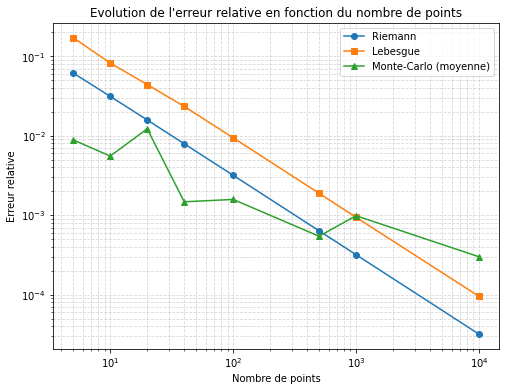

In [14]:
import math
import random

# Fonction à intégrer
f = lambda x: 4/(1+x**2)
a, b = 0, 1

# Valeur exacte via erf
I_exact = math.pi

# Méthode Riemann
def riemann_integral(f, a, b, N):
    dx = (b - a)/N
    total = 0.0
    for i in range(N):
        xi = a + i*dx
        total += f(xi)*dx
    return total

# Méthode Lebesgue
def lebesgue_integral(f, a, b, Nx, Ny):
    x_vals = [a + i*(b-a)/Nx for i in range(Nx)]
    f_vals = [f(x) for x in x_vals]
    f_max = max(f_vals)
    dy = f_max/Ny
    total = 0.0
    for j in range(Ny):
        yj = j*dy
        measure = 0.0
        for x in x_vals:
            if f(x) > yj:
                measure += (b-a)/Nx
        total += measure*dy
    return total

# Méthode Monte-Carlo moyenne sur M tirages
def monte_carlo_integral(f, a, b, N, M=10):
    total = 0.0
    for _ in range(M):
        s = 0.0
        for _ in range(N):
            x = a + (b-a)*random.random()
            s += f(x)
        total += (b-a)*s/N
    return total/M

# Liste des nombres de points
N_points = [5, 10, 20, 40, 100, 500, 1000, 10000]

# Tableaux pour stocker les erreurs relatives
err_riemann = []
err_lebesgue = []
err_mc = []

for N in N_points:
    I_r = riemann_integral(f, a, b, N)
    I_l = lebesgue_integral(f, a, b, Nx=N, Ny=N)
    I_m = monte_carlo_integral(f, a, b, N, M=50)
    
    err_riemann.append(abs(I_r - I_exact)/I_exact)
    err_lebesgue.append(abs(I_l - I_exact)/I_exact)
    err_mc.append(abs(I_m - I_exact)/I_exact)

# Plot des erreurs relatives
plt.figure(figsize=(8,6))
plt.loglog(N_points, err_riemann, 'o-', label='Riemann')
plt.loglog(N_points, err_lebesgue, 's-', label='Lebesgue')
plt.loglog(N_points, err_mc, '^-', label='Monte-Carlo (moyenne)')
plt.xlabel('Nombre de points')
plt.ylabel('Erreur relative')
plt.title('Evolution de l\'erreur relative en fonction du nombre de points')
plt.grid(True, which='both', linestyle='--', alpha=0.5)
plt.legend()
plt.show()
